In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d.proj3d import proj_transform
import pyiast as iast
import seaborn as sns
import numpy as np
from scipy.spatial import ConvexHull
import math
import warnings
import numdifftools as ndt

In /home/cokes/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/cokes/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/cokes/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/cokes/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/cokes/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylel

Cory's build to enable cubic interp


In [2]:
cool_colors = {'green': (0.0, 0.716, 0.554), 'red': (1.0, 0.403, 0.397), 'blue': (0.0, 0.747, 1.0), "yellow": (0.830929, 0.793470, 0.225663), "purple": (0.745987, 0.663119, 1.000000)}

# load gas adsorption data

define set of MOFs and gases.

In [3]:
mofs = ["HKUST-1", "Co-MOF-74"]

gases = ["CH4", 
          "N2", 
         "CO2", 
         "C2H6"
        ]

In [4]:
xtal_density = {"HKUST-1" : 879.1, "Co-MOF-74" : 1172.8} # kg/m^3. see compute_density.jl

mol_wts = {"N2" : 28., "CH4" : 16., "CO2" : 44.009, "C2H6" : 30.07} # g/mol

# for plots
gas_to_color = dict(zip(gases, ["C{0}".format(i) for i in range(len(gases))]))
gas_to_label = {"CH4": "CH$_4$", "N2": "N$_2$", "CO2": "CO$_2$", "C2H6": "C$_2$H$_6$"}
gas_to_symbol = {"CH4": "o", "N2": "s", "CO2": "P", "C2H6": "X"}

read in `.csv` files containing experimental adsorption data from the literature. see the header of the `.csv` for the data source.

In [5]:
isotherm_data = dict()
for mof in mofs:
    isotherm_data[mof] = dict()
    for gas in gases:
        isotherm_data[mof][gas] = pd.read_csv("data/" + mof + "/" + gas + ".csv", comment='#')

unit conversions. goal:
* loading: mmol gas / g MOF [keep it in mmol for IAST!]
* pressure: bar

In [6]:
# special cases for each MOF
isotherm_data["HKUST-1"]["N2"]["p(bar)"] = isotherm_data["HKUST-1"]["N2"]["p(MPa)"] * 10
isotherm_data["HKUST-1"]["CH4"]["N(mmol/g)"] = isotherm_data["HKUST-1"]["CH4"]["cm3/g"] / 22.4

for gas in ["CH4", "N2", "CO2"]:
    isotherm_data["Co-MOF-74"][gas]["N(mmol/g)"] = isotherm_data["Co-MOF-74"][gas]["N(mol/g)"] * 1000.0
    isotherm_data["Co-MOF-74"][gas]["p(bar)"] = isotherm_data["Co-MOF-74"][gas]["p(kPa)"] * 0.01
# where both MOFs need the treatment
for mof in mofs:
    # cm3 STP  *  L STP      *   mol        * 1000mmol
    #  g      1000 cm3 STP    22.4 L STP       1 mol

    isotherm_data[mof]["C2H6"]["p(bar)"] = isotherm_data[mof]["C2H6"]["P(mmHg)"] / 750.062
    # cm3 STP  *  L STP      *   mol      * 1000mmol *    m3 MOF    *   kg      * (100^3) cm3 MOF
    # cm3 MOF  1000 cm3 STP   22.4 L STP     1 mol      ρ_MOF kg      1000 g         m3 MOF
    isotherm_data[mof]["C2H6"]["N(mmol/g)"] = isotherm_data[mof]["C2H6"]["N(cm3STP/cm3)"] * 100 ** 3 / 1000 / 22.4 / xtal_density[mof]
    
# check for success
for mof in mofs:
    for gas in gases:
        try:
            isotherm_data[mof][gas]["N(mmol/g)"]
            isotherm_data[mof][gas]["p(bar)"]
        except KeyError:
            print("failed unit conversion! mof = ", mof, "gas = ", gas)

convert to absolute for the Co-MOF-74 data.

In [7]:
V_pore_co_mof_74 = 0.48 # cm3 / g from Table S1 here: http://www.rsc.org/suppdata/sc/c3/c3sc51319j/c3sc51319j.pdf

In [8]:
bulk_gas_density = dict() # 298 K
for gas in ["CH4", "N2", "CO2"]:
    bulk_gas_density[gas] = pd.read_csv("data/bulk_gas/" + gas + ".cgi", delimiter="\t") # read .cgi files
    
def rho_bulk(gas, p):
    # https://numpy.org/doc/stable/reference/generated/numpy.interp.html
    return np.interp(p, bulk_gas_density[gas]["Pressure (bar)"], bulk_gas_density[gas]["Density (mol/l)"])

In [9]:
# convert vol: mmol/cc = mol/L
for gas in ["CH4", "N2", "CO2"]:
    #  cm3  mol     1 L      1000 mmol
    #   g    L    1000 cm3      1 mol
    # => cm3 / g * mol / L [=] mmol/g
    isotherm_data["Co-MOF-74"][gas]["N(mmol/g)"] = isotherm_data["Co-MOF-74"][gas]["N(mmol/g)"] + V_pore_co_mof_74 * rho_bulk(gas, 
                                                                                                                              isotherm_data["Co-MOF-74"][gas]["p(bar)"])

plot raw data

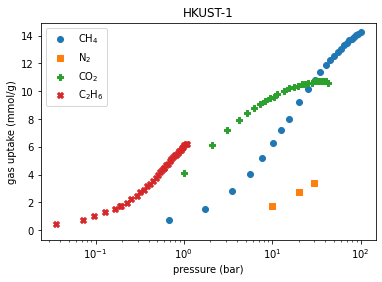

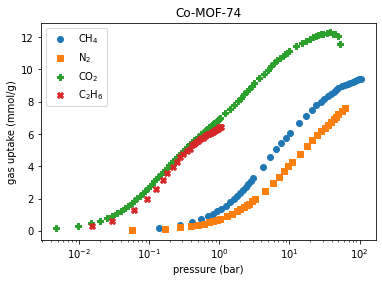

In [10]:
for mof in mofs:
    plt.figure()
    plt.xlabel("pressure (bar)")
    plt.ylabel("gas uptake (mmol/g)")
    for gas in gases:
        plt.scatter(isotherm_data[mof][gas]["p(bar)"], isotherm_data[mof][gas]["N(mmol/g)"], 
                    marker=gas_to_symbol[gas], label=gas_to_label[gas], color=gas_to_color[gas])
    plt.xscale("log")
    plt.title(mof)
    plt.legend()

# fit isotherm models to data for IAST

In [11]:
ads_models = dict()
for mof in mofs:
    ads_models[mof] = dict()
    for gas in gases:
        ads_models[mof][gas] = "Langmuir"
ads_models["Co-MOF-74"]["C2H6"] = "Quadratic"
ads_models["Co-MOF-74"]["CH4"] = "Quadratic"
ads_models["Co-MOF-74"]["CO2"] = "DSLangmuir"

In [12]:
isotherms = dict()
for mof in mofs:
    isotherms[mof] = dict()
    for gas in gases:
        isotherms[mof][gas] = iast.ModelIsotherm(isotherm_data[mof][gas], 
                                                 loading_key="N(mmol/g)", pressure_key="p(bar)", model=ads_models[mof][gas])

In [13]:
isotherms["Co-MOF-74"]["C2H6"].params

{'M': 3.4935519530486188, 'Ka': 4.73447976239299, 'Kb': 30.366262557965044}

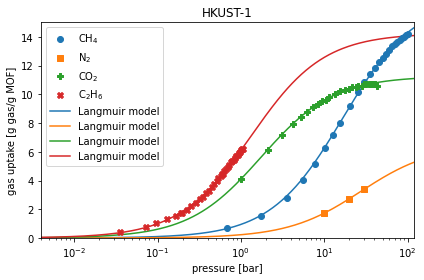

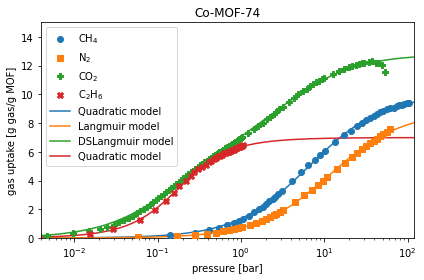

In [16]:
for mof in mofs:
    pressures = np.logspace(-3, 2.5, 500)
    
    plt.figure()# figsize=[0.8*6.4, 0.7*4.8])
    for gas in gases:
        plt.plot(pressures, isotherms[mof][gas].loading(pressures), color=gas_to_color[gas], label=ads_models[mof][gas] + " model")
        plt.scatter(isotherm_data[mof][gas]["p(bar)"], isotherm_data[mof][gas]["N(mmol/g)"], 
                    marker=gas_to_symbol[gas], label=gas_to_label[gas], color=gas_to_color[gas], zorder=1000)
    plt.xscale("log")
    plt.ylim([0, 15])
    plt.xlim([0.004, 120])
    plt.xlabel("pressure [bar]")
    plt.ylabel("gas uptake [g gas/g MOF]")
    plt.title(mof)
    # legend
    handles, labels = plt.gca().get_legend_handles_labels()
    # sort both labels and handles by labels
    plt.legend(handles[4:8] + handles[0:4], labels[4:8] + labels[0:4])

#     plt.legend()
    plt.tight_layout()
    plt.savefig(mof + "isotherms.pdf", format="pdf")

# set up single-MOF IAST calculations
to obtain $m(\mathbf{x})$, the total mass adsorbed in a given MOF with composition at pressure $\mathbf{x}$.

In [15]:
p_total = 1.0 # total pressure [bar]

In [16]:
"""
compute *total* mass of adsorbed gas in the MOF.
returns units: g gas / g MOF

# example:
mol_fxns = {'C2H6': 0.4, 'CH4': 0.6}
adsorbed_mass("HKUST-1", mol_fxns)
"""
def adsorbed_mass(mof, mol_fxns, return_components=False):
    # mol fractions must add to 1.0
    if ~ np.isclose(np.sum([x_i for x_i in mol_fxns.values()]), 1.0):
        raise Exception("mol fxns dont add to 1")
    
    # if any components are zero, remove that component
    mol_fxns = {gas: x_i for gas, x_i in mol_fxns.items() if x_i != 0}
    
    # if we are left with a pure gas, use the pure-component isotherm...
    if len(mol_fxns) == 1:
        gas = list(mol_fxns.keys())[0]
        return isotherms[mof][gas].loading(p_total) * mol_wts[gas] / 1000.0
    
    pressures = np.array([p_total * x_i for x_i in mol_fxns.values()])
    
    q = iast.iast(pressures, [isotherms[mof][gas] for gas in mol_fxns.keys()], warningoff=True)
    
    # q: mmol/g mof
    # mol_wts: g gas/mol 
    # m_ads: g gas/g mof
    total_uptake = np.sum([q[j] * mol_wts[gas] for j, gas in enumerate(mol_fxns.keys())]) / 1000
    
    if return_components:
        gas_uptake = {}
        for j, gas in enumerate(mol_fxns.keys()):
            gas_uptake[gas] = q[j] * mol_wts[gas] / 1000 # g/g
        return gas_uptake
            
    return total_uptake

In [17]:
mol_fxns = {'C2H6': 0.01, 'CH4': 0.99}
adsorbed_mass(mof, mol_fxns, False)

0.026933664127890507

# a single-MOF sensor

In [18]:
"""
convert mol fraction vector with contaminant mole fractions into a mol_fxn dictionary.
"""
def x_to_mol_fxns(x, contaminants):
    assert len(x) == len(contaminants)
    mol_fxns = dict()
    mol_fxns["CH4"] = 1.0 - np.sum(x)
    for i, contaminant in enumerate(contaminants):
        mol_fxns[contaminant] = x[i]
    return mol_fxns

"""
convert mole fraction dict to x
"""
def mol_fxns_to_x(mol_fxns, contaminants):
    return np.array([mol_fxns[contaminant] for contaminant in contaminants])

"""
numerically compute jacobian matrix of m(x) at a given point
"""
def jacobian_matrix_of_m(mof, mol_fxns, contaminants):
    # complicated b/c adsorbed mass takes in a dictionary.
    # construct J(x)
    J = ndt.Jacobian(lambda x: adsorbed_mass(mof, x_to_mol_fxns(x, contaminants)), step=0.001)
    
    # compute x for given mole fractions
    x = mol_fxns_to_x(mol_fxns, contaminants)
    return J(x)

### two contaminants

In [19]:
# draw vector from x0 to x+x0
def sketch_vector(x0, x, label=None, dx_mag=0.015, color="k"):
    plt.arrow(x0[0], x0[1], x[0], x[1], color=color, length_includes_head=True, lw=4)
    dx = dx_mag * x / np.linalg.norm(x)
    plt.text(x0[0] + x[0] + dx[0], x0[1] + x[1] + dx[1], label, ha="center", va="center")
    
    
mof_to_levels = {'HKUST-1': np.linspace(0.0, 0.12, 10),
                'Co-MOF-74': np.linspace(0.0, 0.22, 10)}

create heapmap to visualize $m(\mathbf{x})$

HKUST-1
['N2', 'CO2']


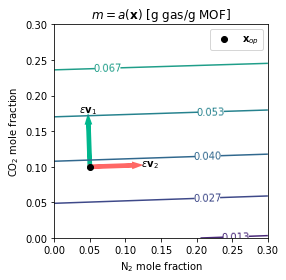

['N2', 'C2H6']


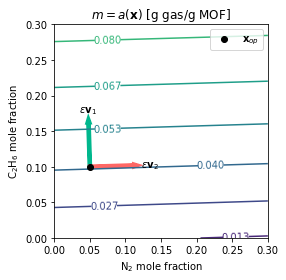

v1 dot [1, 1] =  -0.9691004232811625
v2 dot [1, 1] =  -1.0299729945956213
['C2H6', 'CO2']


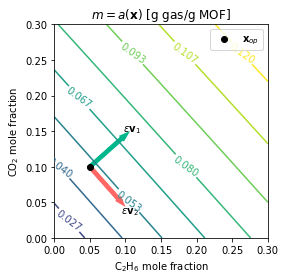

v1 dot [1, 1] =  -1.4118001269794953
v2 dot [1, 1] =  0.08258572189356617
Co-MOF-74
['N2', 'CO2']


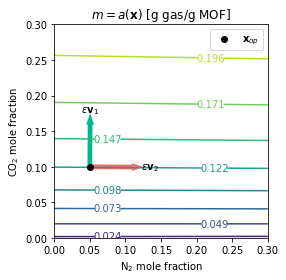

['N2', 'C2H6']


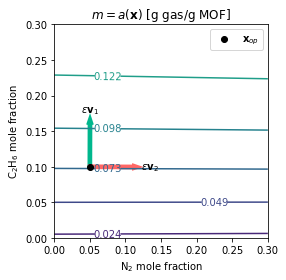

v1 dot [1, 1] =  -1.0034489258081662
v2 dot [1, 1] =  -0.9965391378638555
['C2H6', 'CO2']


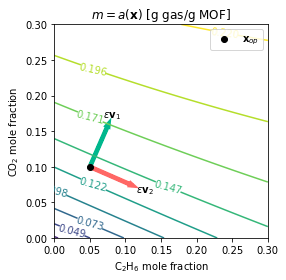

v1 dot [1, 1] =  -1.3164721540300635
v2 dot [1, 1] =  -0.5166246874312579


In [20]:
for mof in mofs:
    print(mof)
    for contaminants in [["N2", "CO2"], ["N2", "C2H6"], ["C2H6", "CO2"]]:
        print(contaminants)
        
        ###
        #   define operating point about which to linearize, compute adsorbed mass at the operating point.
        ###
        mol_fxns_op = {"CH4": 0.85, contaminants[0]: 0.05, contaminants[1]: 0.1}
        mol_fxns_op
        x_op = mol_fxns_to_x(mol_fxns_op, contaminants)
        m_op = adsorbed_mass(mof, mol_fxns_op)
        
        ###
        #    create heatmap to viz m = a(x)
        ###
        delta = 0.005
        x_1 = np.arange(0.00, 0.305, delta)
        x_2 = np.arange(0.00, 0.305, delta)
        X_1, X_2 = np.meshgrid(x_1, x_2)
        M = np.zeros(np.shape(X_1))
        for i in range(np.shape(X_1)[0]):
            for j in range(np.shape(X_2)[1]):
                mol_fxns = x_to_mol_fxns([x_1[i], x_2[j]], contaminants)
                M[j, i] = adsorbed_mass(mof, mol_fxns)

        assert np.sum(np.isnan(M)) == 0
        
        # Jacobian of a(x) at operating point
        J_op = jacobian_matrix_of_m(mof, mol_fxns_op, contaminants)

        # right singular vectors
        v1, v2 = np.linalg.svd(J_op)[2]
        if mof == "HKUST-1" and "N2" in contaminants:
            v2 = - v2
            v1 = - v1
            
        fig, ax = plt.subplots()
        # option to show an image
        # ims = ax.imshow(M, extent=[x_1[0], x_1[-1], x_2[0], x_2[-1]], 
        #                origin='lower',
        #                cmap='viridis', alpha=0.5)
        # plt.colorbar(ims, label="$m$ [g gas/g MOF]")
        CS = ax.contour(X_1, X_2, M, levels=mof_to_levels[mof], vmin=0.0, vmax=np.max(mof_to_levels[mof]))# , colors="k")
        # plt.colorbar(CS, label="$m$ [g gas/g MOF]")
        ax.clabel(CS, inline=True) # labels contours with numbers
        ax.set_title("$m=a(\mathbf{x})$ [g gas/g MOF]")
        ax.set_xlabel(gas_to_label[contaminants[0]] + " mole fraction")
        ax.set_ylabel(gas_to_label[contaminants[1]] + " mole fraction")
        # sketch operating point and directions
        plt.scatter(x_op[0], x_op[1], color="k", label="$\mathbf{x}_{op}$", zorder=1000)
        sketch_vector(x_op, -v1/15, label="$\epsilon\mathbf{v}_1$", color=cool_colors["green"], dx_mag=0.0125)
        sketch_vector(x_op, -v2/15, label="$\epsilon\mathbf{v}_2$", color=cool_colors["red"], dx_mag=0.0175)
        plt.legend()
        # plt.plot([x_op[0], x_op[0] - v1[0]/10], [x_op[1], x_op[1] - v1[1]/10], color='k')
        # plt.plot([x_op[0], x_op[0] - v2[0]/10], [x_op[1], x_op[1] - v2[1]/10], color='k')
        plt.gca().set_aspect('equal', 'box')
        plt.tight_layout()
        plt.savefig(mof + "_" + contaminants[0] + "_" + contaminants[1] + ".pdf", format="pdf", bbox_inches="tight")
        plt.show()
        
        if "C2H6" in contaminants:
            print("v1 dot [1, 1] = ", np.dot(v1, np.array([1, 1])))
            print("v2 dot [1, 1] = ", np.dot(v2, np.array([1, 1])))

for the blind spot toy figure in the intro

In [21]:
def plot_composition(x, savename=None, xlabel="", xmax=0.8):
#     the_bottom = 0.0
#     for gas, x_i in x.items():
#         plt.barh([0.0], [x_i], left=the_bottom, label=gas_to_label[gas])
#         the_bottom = the_bottom + x_i
#     plt.legend()
    plt.figure(figsize=(6.4, 2.0))
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.barh([gas_to_label[gas] for gas in x.keys()], [x_i for x_i in x.values()], color=sns.color_palette("Accent", 3))
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    plt.xlim(xmax=xmax)
    plt.xlabel(xlabel, fontsize=16)
    plt.tight_layout()
    if not (savename == None):
        plt.savefig(savename + ".pdf", format="pdf")

mof =  HKUST-1

x_1 =  {'C2H6': 0.2, 'CO2': 0.01, 'CH4': 0.79}
a(x_1) =  0.06612216575453553

x_2 =  {'C2H6': 0.03388068574856931, 'CO2': 0.19682712178009493, 'CH4': 0.7692921924713357}
a(x_2) =  0.06633094378306202


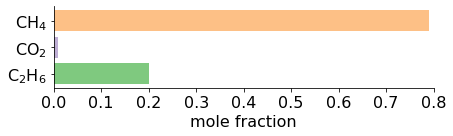

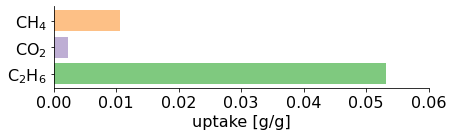

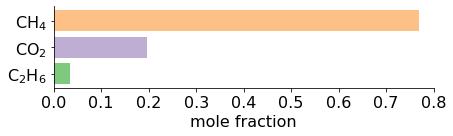

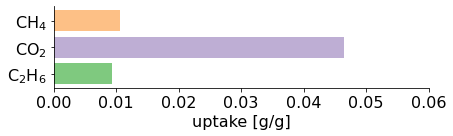

In [22]:
mof = "HKUST-1"
x_1 = {'C2H6': 0.2, 'CO2': 0.01, 'CH4': 1 - 0.01 - 0.2}

print("mof = ", mof)
print("\nx_1 = ", x_1)
print("a(x_1) = ", adsorbed_mass(mof, x_1))
m_1 = adsorbed_mass(mof, x_1, True)

# get blind spot
J_op = jacobian_matrix_of_m(mof, x_1, contaminants)
v1, v2 = np.linalg.svd(J_op)[2]

x_2 = {}
for c in range(len(contaminants)):
    x_2[contaminants[c]] = x_1[contaminants[c]] + v2[c] / 4
x_2['CH4'] = 1.0 - sum(x_2[c] for c in contaminants)
m_2 = adsorbed_mass(mof, x_2, True)

print("\nx_2 = ", x_2)
print("a(x_2) = ", adsorbed_mass(mof, x_2))

        
plot_composition(x_1, xlabel="mole fraction", savename="gas_comp_1")
plot_composition(m_1, xlabel="uptake [g/g]", savename="ads_comp_1", xmax=0.06)
plot_composition(x_2, xlabel="mole fraction", savename="gas_comp_2")
plot_composition(m_2, xlabel="uptake [g/g]", savename="ads_comp_1", xmax=0.06)

## three contaminants

In [23]:
contaminants = ["N2", "CO2", "C2H6"]

discretize composition space

In [37]:
n_pts = 15
max_x = 0.3
X1, X2, X3 = np.mgrid[0:max_x:complex(0,n_pts), 0:max_x:complex(0,n_pts), 0:max_x:complex(0,n_pts)]

In [43]:
for mof in mofs:
    print(mof)
    # store adsorbed mass at each point in a 3D tensor
    M = np.zeros(np.shape(X1))
    for i in range(n_pts):
        for j in range(n_pts):
            for k in range(n_pts):
                mol_fxns = {"CH4": 1 - (X1[i, j, k] + X2[i, j, k] + X3[i, j, k]), 
                            contaminants[0]: X1[i, j, k], 
                            contaminants[1]: X2[i, j, k], 
                            contaminants[2]: X3[i, j, k]}
                M[i, j, k] = adsorbed_mass(mof, mol_fxns)
                
    # define operating point
    mol_fxns_op = {"CH4": 0.35, contaminants[0]: 0.25, contaminants[1]: 0.2, contaminants[2]: 0.2}
    x_op = mol_fxns_to_x(mol_fxns_op, contaminants)
    print("x_op = ", x_op)
    m_op = adsorbed_mass(mof, mol_fxns_op)
    
    # compute Jacobian at operating point and find its right singular vectors
    J_op = jacobian_matrix_of_m(mof, mol_fxns_op, contaminants)

    # right singular vectors
    v1, v2, v3 = np.linalg.svd(J_op)[2]
    v1, v2, v3
    
    print("v1 dot [0, 1, 1]", np.dot(v1, np.array([0, 1 ,1])))
    print("v1 = ", v1, "\n")
    
    # write to file for visualization in mayavi
    np.savez("{}_{}_{}_{}.npz".format(mof, contaminants[0], contaminants[1], contaminants[2]), 
         M=M, X1=X1, X2=X2, X3=X3, v1=v1, v2=v2, v3=v3, x_op=x_op)

HKUST-1
x_op =  [0.25 0.2  0.2 ]
v1 dot [0, 1, 1] 1.4124682712935879
v1 =  [-0.01942431  0.67391241  0.73855586] 

Co-MOF-74
x_op =  [0.25 0.2  0.2 ]
v1 dot [0, 1, 1] -1.2348710624043422
v1 =  [-0.01951371 -0.96179432 -0.27307675] 



# two-MOF sensor array for three contaminants
define the two MOFs and the three contaminants

In [26]:
mofs = ["HKUST-1", "Co-MOF-74"]
contaminants = ["N2", "CO2", "C2H6"]

define an operating point

In [27]:
mol_fxns_op = {"CH4": 0.7, contaminants[0]: 0.05, contaminants[1]: 0.1, contaminants[2]: 0.15}
mol_fxns_op

{'CH4': 0.7, 'N2': 0.05, 'CO2': 0.1, 'C2H6': 0.15}

In [28]:
x_op = mol_fxns_to_x(mol_fxns_op, contaminants)
x_op

array([0.05, 0.1 , 0.15])

In [29]:
m_op = [adsorbed_mass(mof, mol_fxns_op) for mof in mofs]
m_op

[0.07226043704997846, 0.1583979528174021]

compute the Jacobian matrix at the operating point

In [30]:
J_op = [jacobian_matrix_of_m(mof, mol_fxns_op, contaminants) for mof in mofs]
J_op = np.reshape(J_op, (2, 3))

compute the right singular vectors of the Jacobian matrix

In [31]:
# SVD of Jacobian
svd = np.linalg.svd(J_op)
u1, u2 = np.transpose(svd[0])
sigmas = svd[1]
v1, v2, v3 = svd[2]

for drawing arrows in 3D

In [32]:
# https://gist.github.com/WetHat/1d6cd0f7309535311a539b42cccca89c
class Arrow3D(FancyArrowPatch):
    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._xyz = (x, y, z)
        self._dxdydz = (dx, dy, dz)

    def draw(self, renderer):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)

def _arrow3D(ax, x, y, z, dx, dy, dz, muh_label, label_stretch, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''

    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)
    dd = np.array([x+dx, y+dy, z+dz])
    dd = dd / np.linalg.norm(dd)

    ax.text(x+dx+label_stretch*dd[0], y+dy+label_stretch*dd[1], z+dz+label_stretch*dd[2], muh_label, ha="center", va="center")

setattr(Axes3D, 'arrow3D', _arrow3D)

show how a sphere is mapped to an ellipse-ish (this is a non-linear mapping!). use convex hull to show image of sphere in composition space.

In [33]:
n_pts = 35
r = 0.04   # radius of sphere

# construct sphere
theta = np.linspace(0, 2 * np.pi, n_pts)
phi   = np.linspace(0, np.pi, n_pts)

X1 = r * np.outer(np.cos(theta), np.sin(phi)) + x_op[0]
X2 = r * np.outer(np.sin(theta), np.sin(phi)) + x_op[1]
X3 = r * np.outer(np.ones(np.size(theta)), np.cos(phi)) + x_op[2]

assert np.all(X1 > 0) and np.all(X2 > 0) and np.all(X3 > 0)

# find image of these points
M = np.zeros((n_pts**2, 2))
count = 0
for i in range(n_pts):
    for j in range(n_pts):
        mol_fxns = {"CH4": 1 - (X1[i, j] + X2[i, j] + X3[i, j]), 
                    contaminants[0]: X1[i, j], 
                    contaminants[1]: X2[i, j], 
                    contaminants[2]: X3[i, j]}
        for m in range(2):
            M[count, m] = adsorbed_mass(mofs[m], mol_fxns)
        count += 1

# get convex hull of these points
hull = ConvexHull(M)

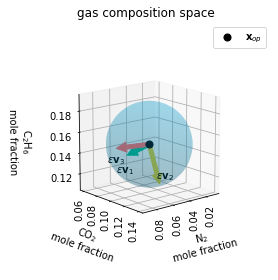

In [34]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

plt.xticks(rotation=90)
plt.yticks(rotation=90)
ax.tick_params(axis="x", pad=0)
ax.tick_params(axis="y", pad=0)
ax.tick_params(axis="z", pad=10)
ax.set_xlabel(gas_to_label[contaminants[0]] + "\nmole fraction", labelpad=22) 
ax.set_ylabel(gas_to_label[contaminants[1]] + "\nmole fraction", labelpad=22) 
ax.set_zlabel(gas_to_label[contaminants[2]] + "\nmole fraction", labelpad=35) 
       
ax.set_title("gas composition space")

ax.scatter(x_op[0], x_op[1], x_op[2], color="k", s=50, label="$\mathbf{x}_{op}$")
v_labels = ["$\epsilon\mathbf{v}_1$", "$\epsilon\mathbf{v}_2$", "$\epsilon\mathbf{v}_3$"]
v_label_stretches = [-0.02, 0.02, -0.02]

for (i, v) in enumerate([v1, v2, v3]):
    color = "k"
    if i == 2:
        color = cool_colors["red"]
    if i == 0:
        color = cool_colors["green"]
    if i == 1:
        color = cool_colors["yellow"]
    ax.arrow3D(x_op[0], x_op[1], x_op[2],
               r*v[0], r*v[1], r*v[2],
               v_labels[i],
               v_label_stretches[i],
               mutation_scale=20,
               ec=color,
               fc=color)
# https://github.com/matplotlib/matplotlib/issues/17172

surf = ax.plot_surface(X1, X2, X3, alpha=0.2, rstride=1, cstride=1, color=cool_colors["blue"])

# ax.set_xlim(xmin=0)
# ax.set_ylim(ymin=0)
# ax.set_zlim(zmin=0)
ax.set_box_aspect([ub - lb for lb, ub in (getattr(ax, f'get_{a}lim')() for a in 'xyz')])

ax.legend()
ax.view_init(elev=15., azim=50)

# plt.plot([0, ax.get_xlim()[1]], [0, 0], [0, 0], c="grey", zorder=1)
# plt.plot([0, 0], [0, ax.get_ylim()[1]], [0, 0], c="grey", zorder=1)
# plt.plot([0, 0], [0, 0], [0, ax.get_zlim()[1]], c="grey", zorder=1)
ax.dist = 15

plt.tight_layout()
plt.savefig("two_mofs_three_contaminants_composition_space.pdf", format="pdf", bbox_inches="tight")
plt.show()

viz sphere to ellipse mapping

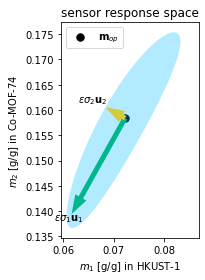

In [35]:
# from x0 to x.
def sketch_vector(x0, x, label=None, dx_mag=0.003, color="k"):#, scale_back=0.924):
    plt.arrow(x0[0], x0[1], x[0], x[1], color=color, head_width=0.0025, length_includes_head=True, lw=2, head_starts_at_zero=False, zorder=100, ec="None")
#     plt.plot([x0[0], x0[0] + x[0]], [x0[1], x0[1] + x[1]], lw=3, color=color) # because head overhangs if not
    dx = dx_mag * x / np.linalg.norm(x)
    plt.text(x0[0] + x[0] + dx[0], x0[1] + x[1] + dx[1], label, ha="center", va="center")
    
fig, ax = plt.subplots()
plt.scatter(m_op[0], m_op[1], label="$\mathbf{m}_{op}$", color="k", s=55)
# plt.plot(x+m_op[0], y+m_op[1], color=cool_colors["blue"], zorder=0, lw=2)
# 
plt.fill(M[hull.vertices, 0], M[hull.vertices, 1], color=cool_colors["blue"], alpha=0.3, ec="None")
ax.set(xlabel="$m_1$ [g/g] in " + mofs[0], ylabel="$m_2$ [g/g] in " + mofs[1], title="sensor response space")
sketch_vector(m_op, sigmas[0] * r * u1, label="$\epsilon\sigma_1\mathbf{u}_1$", color=cool_colors["green"], dx_mag=0.001)
sketch_vector(m_op, sigmas[1] * r * u2, label="$\epsilon\sigma_2\mathbf{u}_2$", color=cool_colors["yellow"], dx_mag=0.003)
# plt.arrow(m_op[0], m_op[1], sigmas[0] * u1[0], sigmas[0] * u1[1], head_width=0.5, length_includes_head=True, color="k")
# plt.arrow(m_op[0], m_op[1], sigmas[1] * u2[0], sigmas[1] * u2[1], head_width=0.5, length_includes_head=True, color="k")
# plt.text(x0[0] + x[0] + dx_label, x0[1] + x[1] + dx_label, label, ha="center", va="center")
ax.set_aspect('equal', 'box')
# plt.xlim(xmin=0.0)
# plt.ylim(ymin=0.0)
plt.xlim(xmax=plt.gca().get_xlim()[1]+0.0025)
# plt.xlim((0.0, 16.02451477673121))
# plt.ylim((0.0, 22.591244938837093))
plt.tight_layout()
plt.legend(loc="upper left")
plt.savefig("two_mofs_three_contaminants_sensor_response.pdf", format="pdf", bbox_inches='tight')